In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from toolbox import read_pixel_data, one_hot_encoding, draw_loss_n_save
from config import *



In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

tf.keras.backend.set_image_data_format('channels_first')

### Load Data

In [3]:
train_X, train_y = read_pixel_data(part='train')
val_X, val_y = read_pixel_data(part='val')
test_X, test_y = read_pixel_data(part='test')
print(f"{'train_X shape':<15}: {train_X.shape}")
print(f"{'train_y shape':<15}: {train_y.shape}")
print(f"{'val_X shape':<15}: {val_X.shape}")
print(f"{'val_y shape':<15}: {val_y.shape}")
print(f"{'test_X shape':<15}: {test_X.shape}")
print(f"{'test_y shape':<15}: {test_y.shape}")

100%|██████████| 450/450 [00:00<00:00, 20014.60it/s]

train_X shape  : (63325, 3, 32, 32)
train_y shape  : (63325,)
val_X shape    : (450, 3, 32, 32)
val_y shape    : (450,)
test_X shape   : (450, 3, 32, 32)
test_y shape   : (450,)


### Preprocessing Data

In [4]:
train_X = train_X / float(255)
val_X = val_X / float(255)
test_X = test_X / float(255)
train_X -= np.mean(train_X)
val_X -= np.mean(val_X)
test_X -= np.mean(test_X)

In [5]:
train_y = one_hot_encoding(train_y, 50)
val_y = one_hot_encoding(val_y, 50)
test_y = one_hot_encoding(test_y, 50)

## Normal Version

### Model

In [13]:
VRAM_USAGE_BEFORE = tf.config.experimental.get_memory_info('GPU:0')['current']
lenet = Sequential([
    layers.Conv2D(6, kernel_size=5, input_shape=train_X.shape[1:], activation='sigmoid'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=5, activation='sigmoid'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='sigmoid'),
    layers.Dense(84, activation='sigmoid'),
    layers.Dense(50, activation='sigmoid'),
])

optimizer = Adam(learning_rate=LEARNING_RATE)
lenet.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])
mckpt = ModelCheckpoint('./checkpoint/', save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
rdlp = ReduceLROnPlateau(monitor='val_loss', mode='min', min_lr=1e-5)
VRAM_USAGE_AFTER = tf.config.experimental.get_memory_info('GPU:0')['current']
print('VRAM USED: ', VRAM_USAGE_AFTER - VRAM_USAGE_BEFORE)
history = lenet.fit(
    train_X, train_y, 
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    shuffle=True, workers=30,
    validation_data=(val_X, val_y),
    callbacks=[mckpt, rdlp])



VRAM USED:  268800
Epoch 1/200
248/248 [==============================] - 7s 8ms/step - loss: 3.9123 - categorical_accuracy: 0.0232 - val_loss: 3.8724 - val_categorical_accuracy: 0.0467 - lr: 0.0010
Epoch 2/200
248/248 [==============================] - 2s 7ms/step - loss: 3.7596 - categorical_accuracy: 0.0518 - val_loss: 3.6660 - val_categorical_accuracy: 0.0733 - lr: 0.0010
Epoch 3/200
248/248 [==============================] - 2s 7ms/step - loss: 3.6198 - categorical_accuracy: 0.0726 - val_loss: 3.5490 - val_categorical_accuracy: 0.1000 - lr: 0.0010
Epoch 4/200
248/248 [==============================] - 2s 7ms/step - loss: 3.5323 - categorical_accuracy: 0.0874 - val_loss: 3.4957 - val_categorical_accuracy: 0.1067 - lr: 0.0010
Epoch 5/200
248/248 [==============================] - 2s 7ms/step - loss: 3.4703 - categorical_accuracy: 0.0976 - val_loss: 3.4477 - val_categorical_accuracy: 0.1156 - lr: 0.0010
Epoch 6/200
248/248 [==============================] - 2s 7ms/step - loss: 3.3990

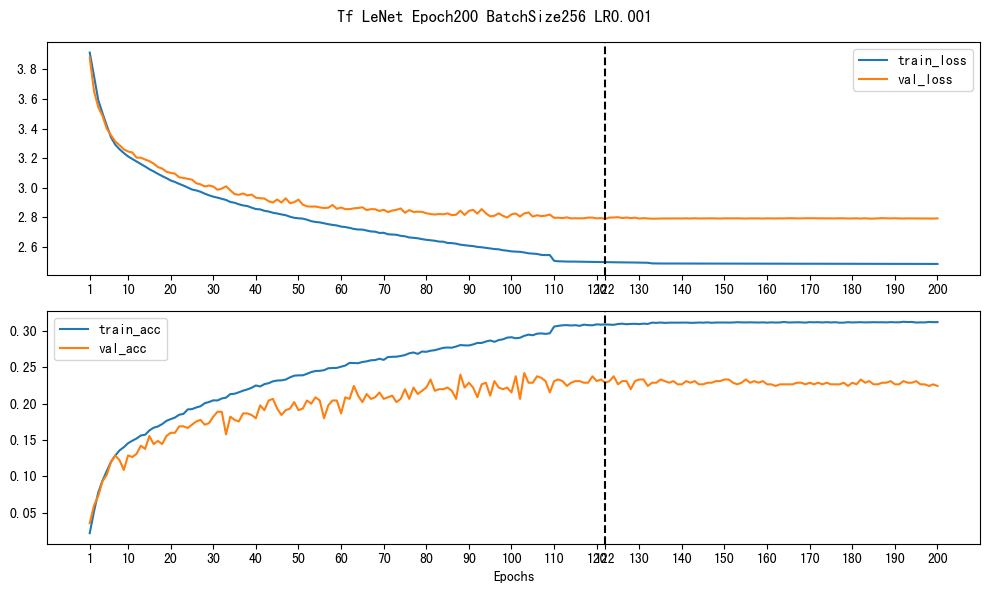

In [13]:
dict_hyper = {'v': 'TF', 'e': EPOCHS, 'b': BATCH_SIZE, 'lr': LEARNING_RATE}

ls_result = list(zip(history.history['loss'], history.history['categorical_accuracy'], 
                history.history['val_loss'], history.history['val_categorical_accuracy']))

draw_loss_n_save(ls_result, dict_hyper)

### Test

In [20]:
%%timeit
pred_y = lenet.predict(test_X, verbose=0)

119 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
test_loss, test_acc = lenet.evaluate(test_X, test_y, verbose=0)
print(f"{'Test Loss':<12}: {round(test_loss, 4)}")
print(f"{'Test Acc':<12}: {round(test_acc, 4)}")

Test Loss   : 2.7417
Test Acc    : 0.2733


In [15]:
pd.DataFrame(ls_result, columns=['train_loss', 'train_acc', 'val_loss', 'val_acc']).reset_index(names='epoch')\
    .to_csv(f"{OUT_PATH}/{dict_hyper['v'].capitalize()}_LeNet_Epoch{dict_hyper['e']}_BatchSize{dict_hyper['b']}_LR{dict_hyper['lr']}.csv", index=False)